In [1]:
%cd ..

/home/ec2-user/uclresearchanalysis


In [2]:
%matplotlib inline
import builtins
# builtins.uclresearch_topic = 'GIVENCHY' #0 -- Finished
builtins.uclresearch_topic = 'HAWKING' #0 -- Finished
# builtins.uclresearch_topic = 'NYC' # 88001
# builtins.uclresearch_topic = 'FLORIDA' # 448387
from configuration import config
from configuration.config import load_ml_data
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from pandas import *
import pandas as pd
from pprint import pprint
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

import pickle
import shap

import multiprocessing
cpu_count = multiprocessing.cpu_count()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

('Reading config file from location: '
 '/home/ec2-user/uclresearchanalysis/configuration/env.properties')
{'calculate': {'analysis': True,
               'network': True,
               'uniquetweets': True,
               'uniqueusers': True},
 'data': {'dates': ['2018-03-13', '2018-03-14', '2018-03-15'],
          'eventname': "hawking's death",
          'phrases': ['stephen%20hawking%20death',
                      'stephen%20hawking%20die',
                      'stephen%20hawking%20passed%20away'],
          'starttime': 'Mar 13 12:00:00 -0500 2018'},
 'path': {'crawl': {'followers': '/home/ec2-user/uclresearchanalysis/followers',
                    'friends': '/home/ec2-user/uclresearchanalysis/friends'},
          'cwd': '/home/ec2-user/uclresearchanalysis/data/hawking',
          'ml': '/home/ec2-user/uclresearchanalysis/data/hawking/pickle',
          'networkx': {'all': '/home/ec2-user/uclresearchanalysis/data/hawking/pickle/networkx_all.dat',
                       'frien

In [3]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
# Parameters
interval = 30

# 1. Prepare
def prepare_data(interval):
    df = load_ml_data(interval)
    df = df.reset_index(drop=True)
    
    # Converting all type to float, to prepare for feature selection
    df = df.astype('float')
    # Reset index, with drop equals to true to avoid setting old index as a new column
    df = df.reset_index(drop=True)
    # Visualize distribution
    print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
        df['label'].value_counts()[0],
        df['label'].value_counts()[1]
    ))
    df.groupby(['TwM_tCurrent','label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')
    
    columns = list(df.columns)
    columns.remove('label')
    
    X = df[columns]
    y = df[['label']]
    return df, X, y


Loading data file from path /home/ec2-user/uclresearchanalysis/data/hawking/pickle/30_data.dat
'Loaded 2033529 entires'
[Original] data counts, with uninfected (0): 1818420, infected (1): 215109


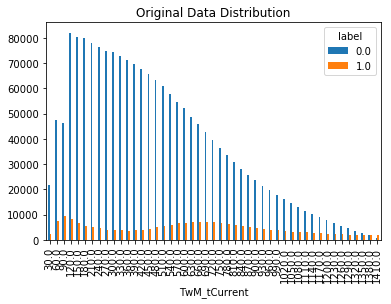

In [5]:
# 1. Prepare
df, X, y = prepare_data(interval)

In [6]:
feature_columns = X.columns
print('There are {} Features'.format(len(feature_columns)))

There are 88 Features


In [7]:
def upsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print(df_upsampled.label.value_counts())
    
    return df_upsampled

In [8]:
def downsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=len(df_minority),     # to match minority class
                                     random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    # Display new class counts
    print(df_downsampled.label.value_counts())
    
    return df_downsampled

In [9]:
def train(df, X, y, params, n_folds, num_boost_round, rebalance_method):
    # 2. N Fold Split
    # Stratified K-Folds cross-validator
    # Provides train/test indices to split data in train/test sets. 
    # This cross-validation object is a variation of KFold that returns stratified folds. 
    # The folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    corrDataframe = pd.DataFrame()    
    mse = []
    acc = []
    roc = []
    F1 = []
    auc = []
    auc_t = []
    acc_t = []
    fold_count = 0
    t_current = 210
    number_of_features = len(X.columns)

    print("Start cross validation")
    for train, test in skf.split(X, y):
        print("===Processing fold %s===" % fold_count)
        train_fold = df.loc[train]
        test_fold = df.loc[test]

        # 3. Rebalance
        if rebalance_method == 'up':
            train_fold = upsample(train_fold)
        if rebalance_method == 'down':
            train_fold = downsample(train_fold)
         
        # 4. Feature Selection
#         corr = train_fold.corr()['label'][train_fold.corr()['label'] < 1].abs()
#         corr = corr.sort_values(ascending=False)
#         corrDataframe = corrDataframe.append(pd.DataFrame(corr.rename('cv{}'.format(fold_count))).T)
#         features = corr.index[range(number_of_features)].values
        features = X.columns
        
        # 5. Training
        # Fit Model
        xgtrain = xgb.DMatrix(train_fold[features].values, train_fold['label'].values)
        xgtest = xgb.DMatrix(test_fold[features].values, test_fold['label'].values)
        evallist = [(xgtrain, 'train'),(xgtest,'eval')]
#         evallist = []
        
        bst = xgb.train(params, xgtrain, 
                        num_boost_round = num_boost_round, 
                        evals = evallist)

        # 6. Testing
        # Check MSE on test set
        
        test_fold_t = test_fold[test_fold.TwM_tCurrent == t_current]
#             xgtest = xgb.DMatrix(test_fold[features].values)
        xgtest_t = xgb.DMatrix(test_fold_t[features].values)
        pred = bst.predict(xgtest)
        pred_t = bst.predict(xgtest_t)

        mse.append(mean_squared_error(test_fold['label'], pred))
        roc.append(roc_auc_score(test_fold['label'], pred))
        auc_t.append(roc_auc_score(test_fold_t['label'], pred_t))

        acc.append(accuracy_score(test_fold['label'], (pred>0.5).astype(int)))
        acc_t.append(accuracy_score(test_fold_t['label'], (pred_t>0.5).astype(int)))
        F1.append(f1_score(test_fold['label'],(pred>0.5).astype(int)))
        cm = confusion_matrix(test_fold['label'], (pred>0.5).astype(int))
        plot_confusion_matrix(cm, 
                              normalize    = True,
                              target_names = ['Uninfected', 'Infected'],
                              title        = "Confusion Matrix, Normalized")


        fold_count += 1
        # Done with the fold
    print("Finished cross validation")
    print("MSE: {} ".format(DataFrame(mse).mean()))
    print("ACC: {} ".format(DataFrame(acc).mean()))
    print("AUC: {} ".format(DataFrame(roc).mean()))
#     print("F1: {} ".format(DataFrame(F1).mean()))
    print("ACC for t at {}: {} ".format(t_current, DataFrame(acc_t).mean()))
    corrDataframe = corrDataframe.T
    corrDataframe['average corr'] = corrDataframe.mean(numeric_only=True, axis=1)
    print(corrDataframe.sort_values(by=['average corr'], ascending=False).to_string())

    return bst


In [12]:
#xgboost
param = {
    'max_depth':3,
    # Step size shrinkage used in update to prevents overfitting. 
    # After each boosting step, we can directly get the weights of new features, 
    # and eta shrinks the feature weights to make the boosting process more conservative.
    'eta': 0.1,
    # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
    # The larger gamma is, the more conservative the algorithm will be.
    'gamma':10,
    # Minimum sum of instance weight (hessian) needed in a child. 
    # If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, 
    # then the building process will give up further partitioning.
    # The larger min_child_weight is, the more conservative the algorithm will be.
    'min_child_weight':10,
    'silent': 1, # 0 means printing running messages, 1 means silent mode
    'objective': 'binary:logistic',
    'subsample': 0.9
}
param['nthread'] = cpu_count
param['eval_metric'] = ['auc']
num_boost_round = 10
rebalance_method = 'up'

Start cross validation
===Processing fold 0===
1.0    909210
0.0    909210
Name: label, dtype: int64
[0]	train-auc:0.689501	eval-auc:0.689261
[1]	train-auc:0.706759	eval-auc:0.706546
[2]	train-auc:0.709344	eval-auc:0.709514
[3]	train-auc:0.709868	eval-auc:0.709987
[4]	train-auc:0.711225	eval-auc:0.711581
[5]	train-auc:0.714547	eval-auc:0.714678
[6]	train-auc:0.718162	eval-auc:0.718399
[7]	train-auc:0.72292	eval-auc:0.722906
[8]	train-auc:0.723703	eval-auc:0.723561
[9]	train-auc:0.725189	eval-auc:0.725051


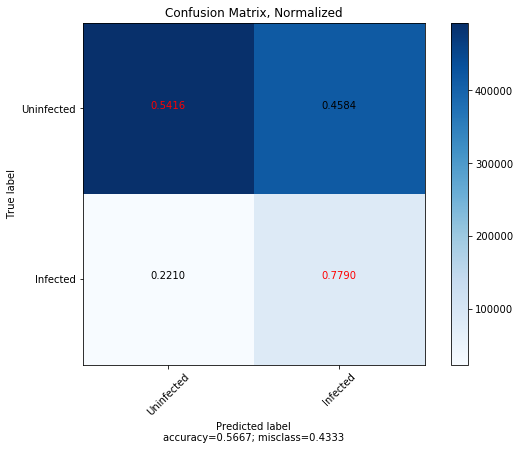

===Processing fold 1===
1.0    909210
0.0    909210
Name: label, dtype: int64
[0]	train-auc:0.688918	eval-auc:0.686932
[1]	train-auc:0.706279	eval-auc:0.704553
[2]	train-auc:0.709209	eval-auc:0.707681
[3]	train-auc:0.711582	eval-auc:0.710136
[4]	train-auc:0.717338	eval-auc:0.71574
[5]	train-auc:0.717929	eval-auc:0.716303
[6]	train-auc:0.719601	eval-auc:0.718124
[7]	train-auc:0.719808	eval-auc:0.718409
[8]	train-auc:0.723734	eval-auc:0.722481
[9]	train-auc:0.724151	eval-auc:0.722777


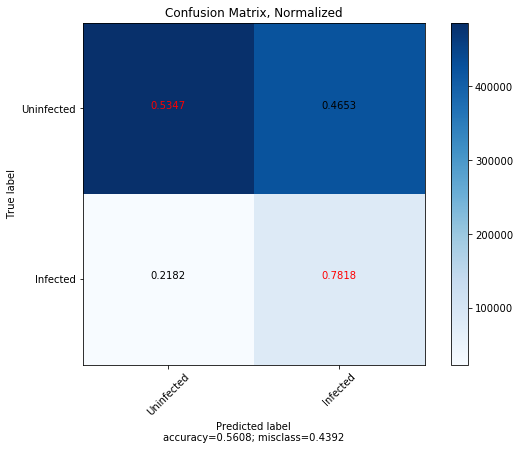

Finished cross validation
MSE: 0    0.220579
dtype: float64 
ACC: 0    0.563773
dtype: float64 
AUC: 0    0.723914
dtype: float64 
ACC for t at 210: 0    0.746851
dtype: float64 
Empty DataFrame
Columns: [average corr]
Index: []


In [13]:
xgb_model = train(df, X, y, param, 2, num_boost_round, rebalance_method)

In [16]:
columns = list(df.columns)
columns.remove('label')
if rebalance_method == 'up':
    df_rebalance = upsample(df)
if rebalance_method == 'down':
    df_rebalance = downsample(df)
X = df_rebalance[columns]
y = df_rebalance[['label']]

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model

model = xgb.train(param, xgb.DMatrix(X, label=y), num_boost_round)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

1.0    1818420
0.0    1818420
Name: label, dtype: int64


In [ ]:
with open('xgb_model.dat', 'wb') as file:
    pickle.dump(model, file)

In [17]:
subsample = list(range(1,len(shap_values),int(len(shap_values)/1000)))

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[subsample,:], X.iloc[subsample,:])

In [ ]:
X.columns[0]

In [ ]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot(X.columns[0], shap_values, X)

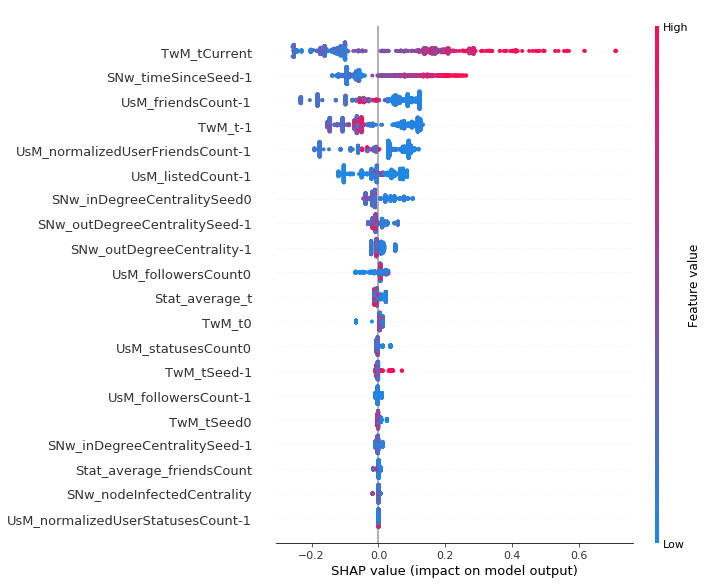

In [18]:
# summarize the effects of all the features
shap.summary_plot(shap_values[subsample,:], X.iloc[subsample,:])

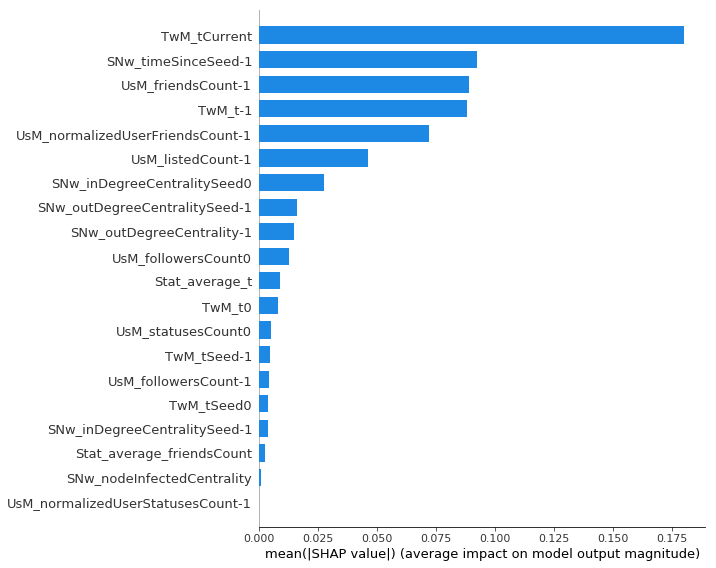

In [19]:
shap.summary_plot(shap_values[subsample,:], X.iloc[subsample,:], plot_type="bar")

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(xgb_model, num_trees=1)

fig = plt.gcf()
fig.set_size_inches(100, 50)
plt.show()

In [ ]:
xgb.plot_importance(xgb_model)
fig = plt.gcf()
# fig.set_size_inches(50, 100)
plt.show()